# 0. IMPORTS

In [1]:
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

from kaggle.api.kaggle_api_extended import KaggleApi
import warnings
from os import remove
from zipfile import ZipFile
import pickle

## 0.1. Helper Functions

In [2]:
def silhouette_print(X, n_clusters):

    model = KMeans(n_clusters = n_clusters, n_init = 50, random_state = seed)
    y = model.fit_predict(X)
    
    # Calculando as silhuetas de cada amostra
    silhouette_vals = silhouette_samples(X, y)

    # Calculando a pontuação média de silhueta do conjunto de dados
    silhouette_avg = silhouette_score(X, y)

    # Plotando as silhuetas de cada amostra e seus clusters correspondentes
    fig, ax = plt.subplots()
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(y)):
        cluster_silhouette_vals = silhouette_vals[y == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i))
        y_lower += len(cluster_silhouette_vals)
        y_ticks.append((y_lower + y_upper) / 2)
    
    plt.title("K = {}".format(n_clusters))
    
    # Plotando a linha de silhueta média
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(np.unique(y))
    ax.set_ylabel("Cluster")
    ax.set_xlim([-0.2, 1])
    ax.set_xlabel("Silhouette coefficient")
    plt.show()

## 0.2. Basic Settings

In [3]:
warnings.filterwarnings('ignore')
seed = 0

## 0.3. Loading Data

In [4]:
kaggle = KaggleApi()
kaggle.authenticate()

kaggle.dataset_download_file('carrie1/ecommerce-data', 'data.csv');

with ZipFile('data.csv.zip', 'r') as Zip:
    Zip.extractall()
    
df_raw = pd.read_csv('data.csv', encoding = 'unicode_escape')

remove('data.csv')
remove('data.csv.zip')

# 1. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

## 1.2. Data Dimensions

In [6]:
print('Number of Columns: {}'.format(df1.shape[1]))
print('Number of Rows: {}'.format(df1.shape[0]))

Number of Columns: 8
Number of Rows: 541909


## 1.3. Data Types

In [7]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 1.5. Fillout NA

In [9]:
df1 = df1.dropna()

## 1.6. Changing Data Types

In [10]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

## 1.7. Descriptive Statistics

In [11]:
num_attr = df1[["Quantity", "UnitPrice"]]
cat_attr = df1[["InvoiceNo", "StockCode", "Country"]]

### 1.7.1. Numerical Attributes

In [12]:
minimum = pd.DataFrame(num_attr.min())
maximum = pd.DataFrame(num_attr.max())
range_ = maximum - minimum
mean = pd.DataFrame(num_attr.mean())
median = pd.DataFrame(num_attr.median())
std = pd.DataFrame(num_attr.std())
skew = pd.DataFrame(num_attr.skew())
kurtosis = pd.DataFrame(num_attr.kurtosis())

description = pd.concat([minimum, maximum, range_, mean, median, std, skew, kurtosis], axis = 1)
description.columns = ['Min', 'Max', 'Range', 'Mean', "Median", 'StD', 'Skew', 'Kurtosis']
description

,Min,Max,Range,Mean,Median,StD,Skew,Kurtosis
Quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693370,0.182663,94317.563673
UnitPrice,0.0,38970.0,38970.0,3.460471,1.95,69.315162,452.219019,246924.542988


### 1.7.2. Categorical Attributes

In [13]:
cat_attr.describe()

,InvoiceNo,StockCode,Country
count,406829,406829,406829
unique,22190,3684,37
top,576339,85123A,United Kingdom
freq,542,2077,361878


# 2. VARIABLE FILTERING

In [14]:
df2 = df1.copy()

## 2.1. Row Filtering

In [15]:
df2 = df2[df2['StockCode'].str.match("[^A-Z]")]

## 2.2. Columns Filtering

# 3. FEATURE ENGINEERING

In [16]:
df3 = df2.copy()

## 3.1. Hypoteses

## 3.2. Features Creation

### 3.2.1. Time Parameters

In [17]:
today = df3['InvoiceDate'].max()
time_min = today - datetime.timedelta(days = 30)
time_interval = (today - time_min).days

### 3.2.2. Source Data

In [18]:
df3['TotalPrice'] = df3.apply(lambda x: x['Quantity'] * x['UnitPrice'], axis = 1)

### 3.2.3. Features DataFrame

In [19]:
df_feat = df3[['CustomerID']].drop_duplicates().sort_values(by = 'CustomerID', ascending = True).reset_index(drop = True)

#### 3.2.3.1. Recency (Days)

In [20]:
recency = df3[df3['Quantity'] > 0].groupby('CustomerID').max()[['InvoiceDate']].reset_index().rename(columns = {'InvoiceDate' : "Recency"})
recency["Recency"] = recency['Recency'].apply(lambda x: (today - x).days)

df_feat = df_feat.merge(recency, on = "CustomerID", how = "left").fillna(0)

#### 3.2.3.2. Frequency (Purchases/Day over time)

In [21]:
frequency = df3[df3['Quantity'] > 0][df3['InvoiceDate'] > time_min][['CustomerID', "InvoiceNo"]].drop_duplicates().groupby(['CustomerID']).count().reset_index().rename(columns = {'InvoiceNo' : 'Frequency'})
frequency['Frequency'] = frequency["Frequency"]/time_interval

df_feat = df_feat.merge(frequency, on = "CustomerID", how = "left")

#### 3.2.3.3. Monetary

In [22]:
monetary = df3[['TotalPrice', 'CustomerID']].groupby('CustomerID').sum().reset_index().rename(columns = {"TotalPrice" : "Monetary"})

df_feat = df_feat.merge(monetary, on = 'CustomerID', how = 'left')

#### 3.2.3.4 Mean Basket Size

In [23]:
basket_size = df3[['CustomerID', 'InvoiceNo', "Quantity"]].groupby(["CustomerID", "InvoiceNo"]).sum().reset_index()
basket_size = basket_size[["CustomerID", "Quantity"]].groupby('CustomerID').mean().reset_index().rename(columns = {"Quantity" : "MeanBasketSize"})

df_feat = df_feat.merge(basket_size, on = 'CustomerID', how = 'left')

#### 3.2.3.5. Mean Average Ticket

In [24]:
mean_average_ticket = df3[["CustomerID", "InvoiceNo", "TotalPrice"]].groupby(['CustomerID', "InvoiceNo"]).sum().reset_index()
mean_average_ticket = mean_average_ticket[['CustomerID', "TotalPrice"]].groupby("CustomerID").mean().reset_index().rename(columns = {'TotalPrice' : "MeanAverageTicket"})

df_feat = df_feat.merge(mean_average_ticket, on = "CustomerID", how = 'left')

#### 3.2.3.6. Total Quantity Purchased

In [25]:
total_quantity = df3[['CustomerID', "Quantity"]].groupby("CustomerID").sum().reset_index().rename(columns = {"Quantity" : "TotalQuantity"})

df_feat = df_feat.merge(total_quantity, on = "CustomerID", how = 'left')

#### 3.2.3.7. Number of Returns

In [26]:
total_return = df3[df3["Quantity"] < 0][['CustomerID', "Quantity"]].groupby("CustomerID").sum().reset_index().rename(columns = {"Quantity" : "TotalReturn"})

df_feat = df_feat.merge(total_return, on = "CustomerID", how = 'left').fillna(0)

#### 3.2.3.8. Average Purchase Interval

In [27]:
aux = df3[df3['Quantity'] > 0][['CustomerID', "InvoiceDate"]].drop_duplicates().sort_values(by = ['CustomerID', "InvoiceDate"])
aux["NextCustomer"] = aux['CustomerID'].shift()
aux['NextInvoice'] = aux['InvoiceDate'].shift()
aux["AveragePurchaseInterval"] = aux.apply(lambda x: (x["InvoiceDate"] - x['NextInvoice']).days if x['CustomerID'] == x['NextCustomer'] else np.nan, axis = 1)
aux = aux.dropna()
aux2 = aux[["CustomerID", "AveragePurchaseInterval"]].groupby('CustomerID').mean().reset_index()

aux3 = df_feat.merge(aux2, on = "CustomerID", how = 'left')
aux4 = df3[['CustomerID', "InvoiceDate"]].groupby("CustomerID").max()
aux3 = aux3.merge(aux4, on = "CustomerID", how = 'left')
aux3 = aux3.apply(lambda x: x.fillna( (today - x['InvoiceDate']).days), axis = 1)
aux3.drop("InvoiceDate", inplace = True, axis = 1)

df_feat = aux3

# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [28]:
df4 = df_feat.copy()

## 4.1. Univariate Analysis

## 4.2. Bivariate Analysis

## 4.3. Embedding Space

### 4.3.1. PCA

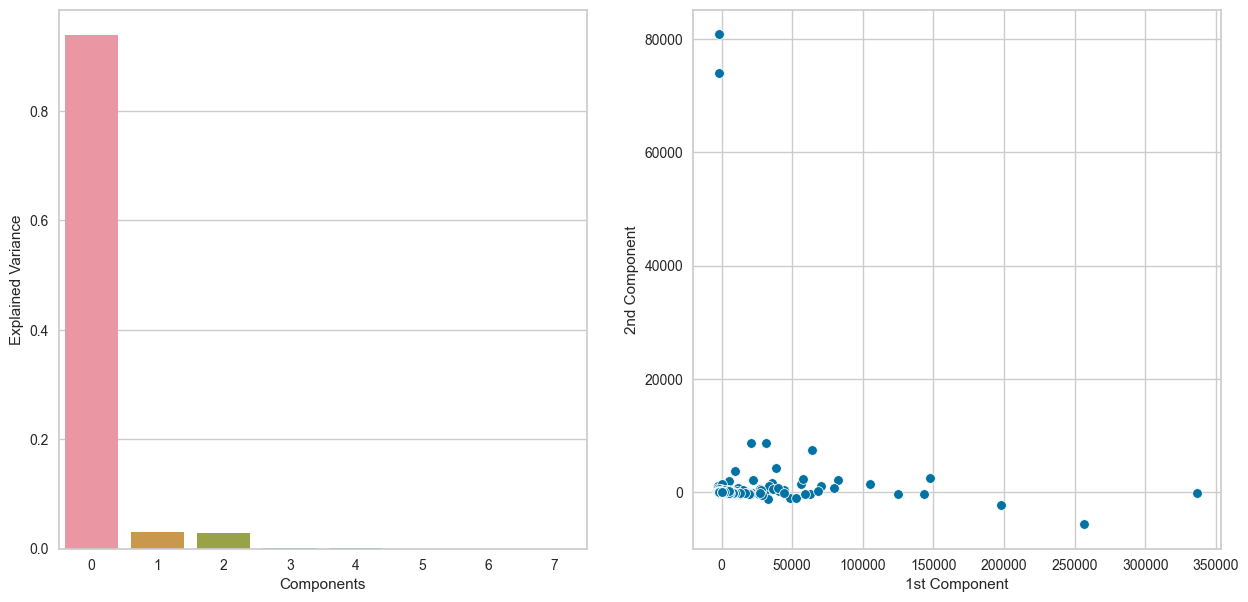

In [29]:
L = df_feat.drop(['CustomerID'], axis = 1).shape[1]
pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(df_feat.drop(['CustomerID'], axis = 1)))

plt.figure(figsize = [15, 7])

plt.subplot(1, 2, 1)
sns.barplot(x = list(range(0, L)), y = pca.explained_variance_ratio_);
plt.xlabel("Components")
plt.ylabel("Explained Variance")

plt.subplot(1, 2, 2)
sns.scatterplot(x = 0, y = 1, data = pca_data);
plt.xlabel("1st Component")
plt.ylabel("2nd Component");

### 4.3.2. t-SNE

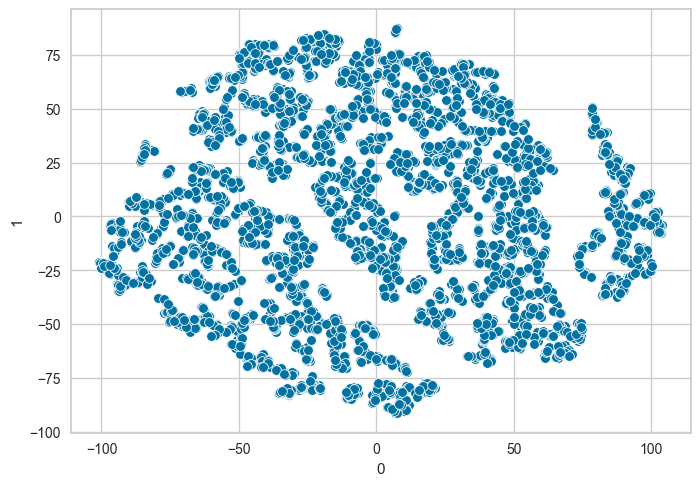

In [30]:
reducer = TSNE(n_components = 2, perplexity = 10, n_jobs = -1, random_state = seed)
tsne = pd.DataFrame(reducer.fit_transform(df_feat.drop('CustomerID', axis = 1)))

sns.scatterplot(x = 0, y = 1, data = tsne);

# 5. DATA PREPARATION

In [31]:
df5 = df4.copy()

## 5.1. Scaler

In [32]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
aux = pd.DataFrame(ss.fit_transform(df5), columns = df5.columns)
aux['CustomerID'] = df5['CustomerID']
df5 = aux

# 6. FEATURE SELECTION

In [33]:
df6 = df5.copy()

In [34]:
cols_selected = ['Recency', 'Frequency', 'Monetary', 'MeanBasketSize',
       'MeanAverageTicket', 'TotalQuantity', 'TotalReturn',
       'AveragePurchaseInterval']

In [35]:
df6 = df6.loc[:, cols_selected]

# 7. HYPERARAMETERS FINE TUNING

In [36]:
df7 = df6.copy()

In [37]:
n_clusters = 20
clusters_range = list(range(2, n_clusters + 1))

## 7.1. Elbow Method

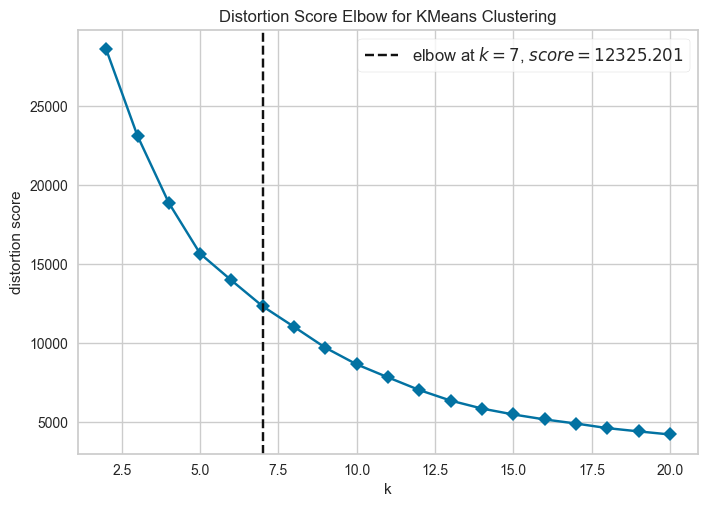

In [38]:
model = KMeans(n_init = 50, random_state = seed)
visualizer = KElbowVisualizer(model, k=n_clusters, timings = False)

visualizer.fit(df7)       
visualizer.show();

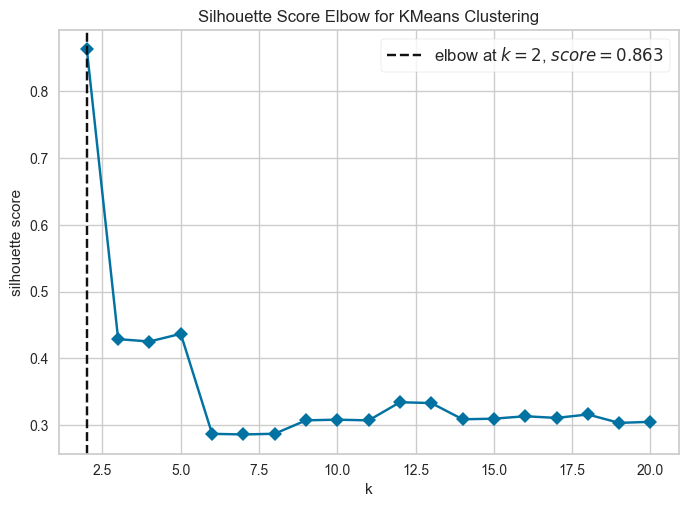

In [39]:
model = KMeans(n_init = 50, random_state = seed)
visualizer = KElbowVisualizer(model, k = n_clusters, timings = False, metric = 'silhouette')

visualizer.fit(df7)       
visualizer.show();

## 7.2. Silhouette Analysis

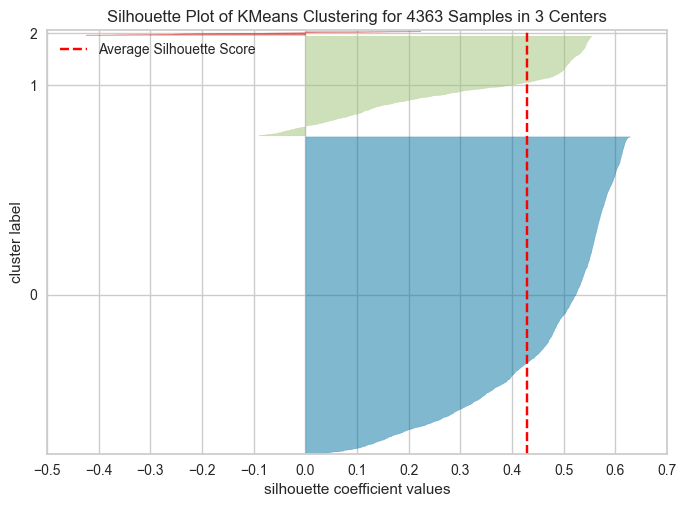

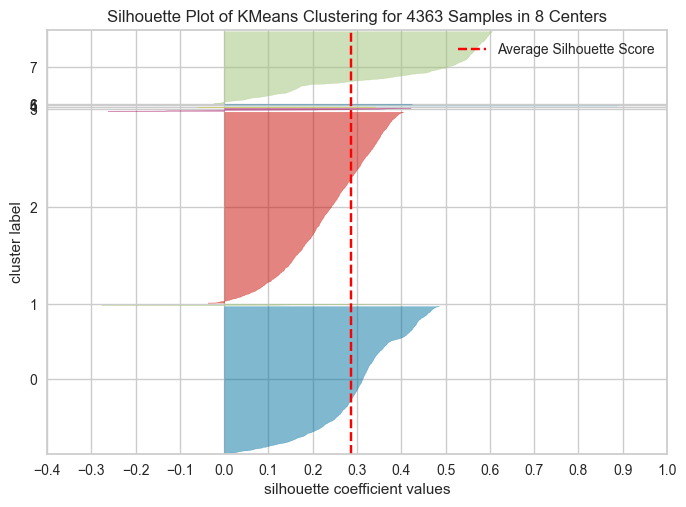

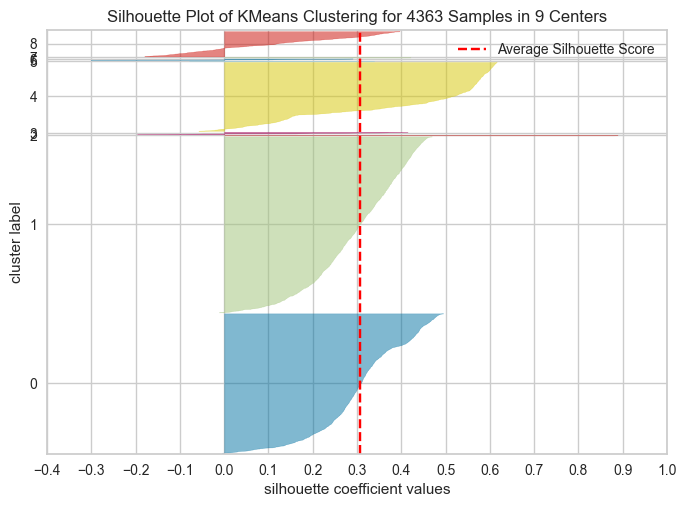

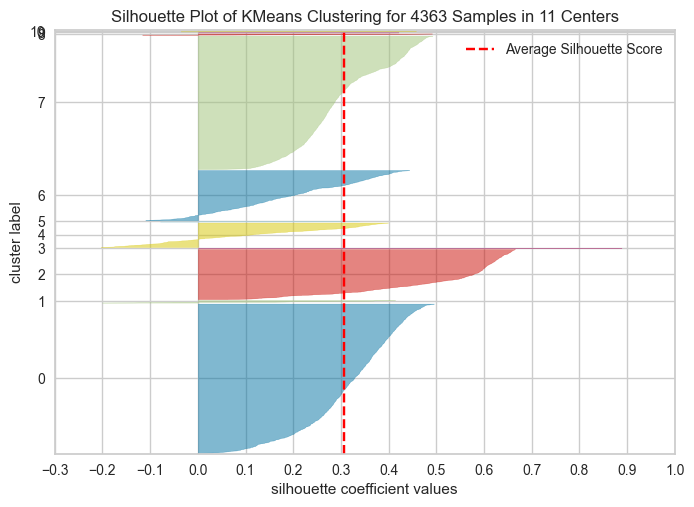

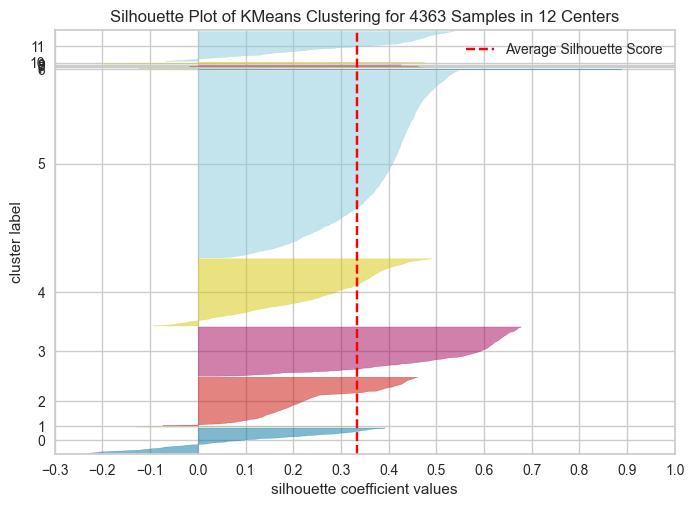

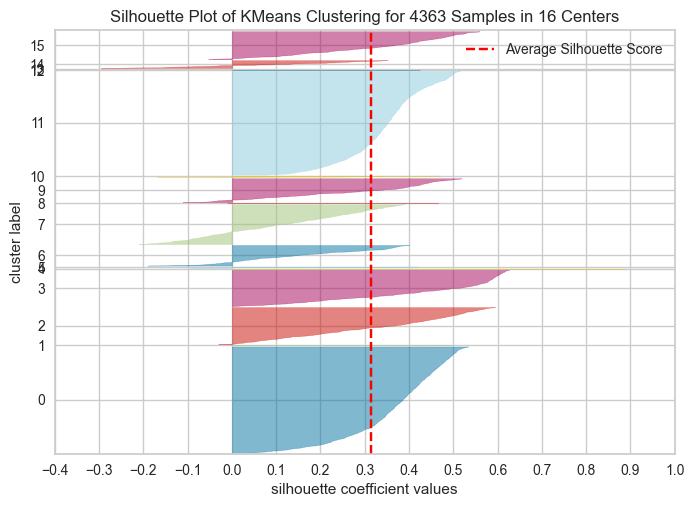

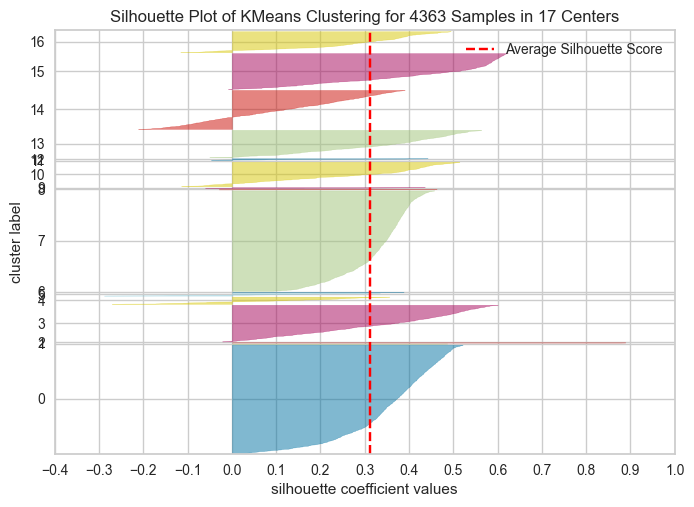

In [40]:
clusters_list = [3, 8, 9, 11, 12, 16, 17]

for i in clusters_list:
    model = KMeans(i, n_init = 50, random_state = seed)
    viz = SilhouetteVisualizer(model, colors='yellowbrick')
    viz.fit(df7)       
    viz.show();

# 8. MACHINE LEARNING MODELLING

In [41]:
df8 = df7.copy()

In [42]:
K = 12

## 8.1. K-Means

In [43]:
model_kmeans = KMeans(n_clusters = K, n_init = 50, init = 'random', random_state = seed)
pred_kmeans = model_kmeans.fit_predict(df8)
sil_kmeans = silhouette_score(df8, pred_kmeans)
sil_kmeans

0.3090021589248768

## 8.2. Hierarchical Clustering

In [44]:
model_hier = AgglomerativeClustering(n_clusters = K, affinity='euclidean', linkage='single')
pred_hier = model_hier.fit_predict(df8)
sil_hier = silhouette_score(df8, pred_hier)
sil_hier

0.8432747915938329

## 8.3. Gaussian Mixture Model

In [45]:
model_gmm = GMM(n_components = K)
pred_gmm = model_gmm.fit_predict(df8)
sil_gmm = silhouette_score(df8, pred_gmm)
sil_gmm

-0.007289402546508839

## 8.4. DBSCAN

model_dbscan = DBSCAN()
pred_dbscan = model_dbscan.fit_predict(df8)
sil_dbscan = silhouette_score(df8, pred_dbscan)
sil_dbscan

## 8.5. Results Comparison

In [46]:
pd.DataFrame([sil_kmeans, sil_hier, sil_gmm], index = ['Kmeans', 'Hierarchical', 'GMM'], columns = ['Silhouette Score'])

,Silhouette Score
Kmeans,0.309002
Hierarchical,0.843275
GMM,-0.007289


## 8.6. Final Model

In [47]:
final_model = model_hier

# 9. CLUSTER ANALYSIS

In [48]:
df9 = df8.copy()
final_pred = final_model.fit_predict(df9)
df9['cluster'] = final_pred

df9.head()

,Recency,Frequency,Monetary,MeanBasketSize,MeanAverageTicket,TotalQuantity,TotalReturn,AveragePurchaseInterval,cluster
0,2.336530,-0.449640,-0.229818,-0.612029,-0.823049,-0.240133,-44.020909,2.334250,1
1,-0.900000,0.269751,0.291698,0.458679,0.750203,0.285240,0.036667,-0.434091,0
2,-0.170782,-0.449640,-0.055910,1.165660,0.095048,0.258309,0.036667,-0.081947,0
3,-0.730182,0.269751,-0.053453,1.308973,2.901232,-0.105477,0.036667,-0.876887,0
4,2.176701,-0.449640,-0.194196,-0.014384,-0.070808,-0.198240,0.036667,2.166894,0


## 9.1. Silhouette Inspection

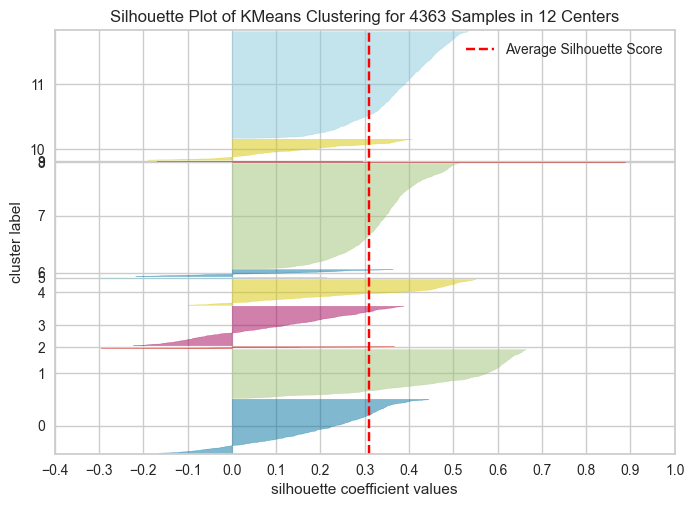

In [49]:
    viz = SilhouetteVisualizer(model_kmeans, colors='yellowbrick')
    viz.fit(df8)       
    viz.show();

## 9.2. 2D Plot

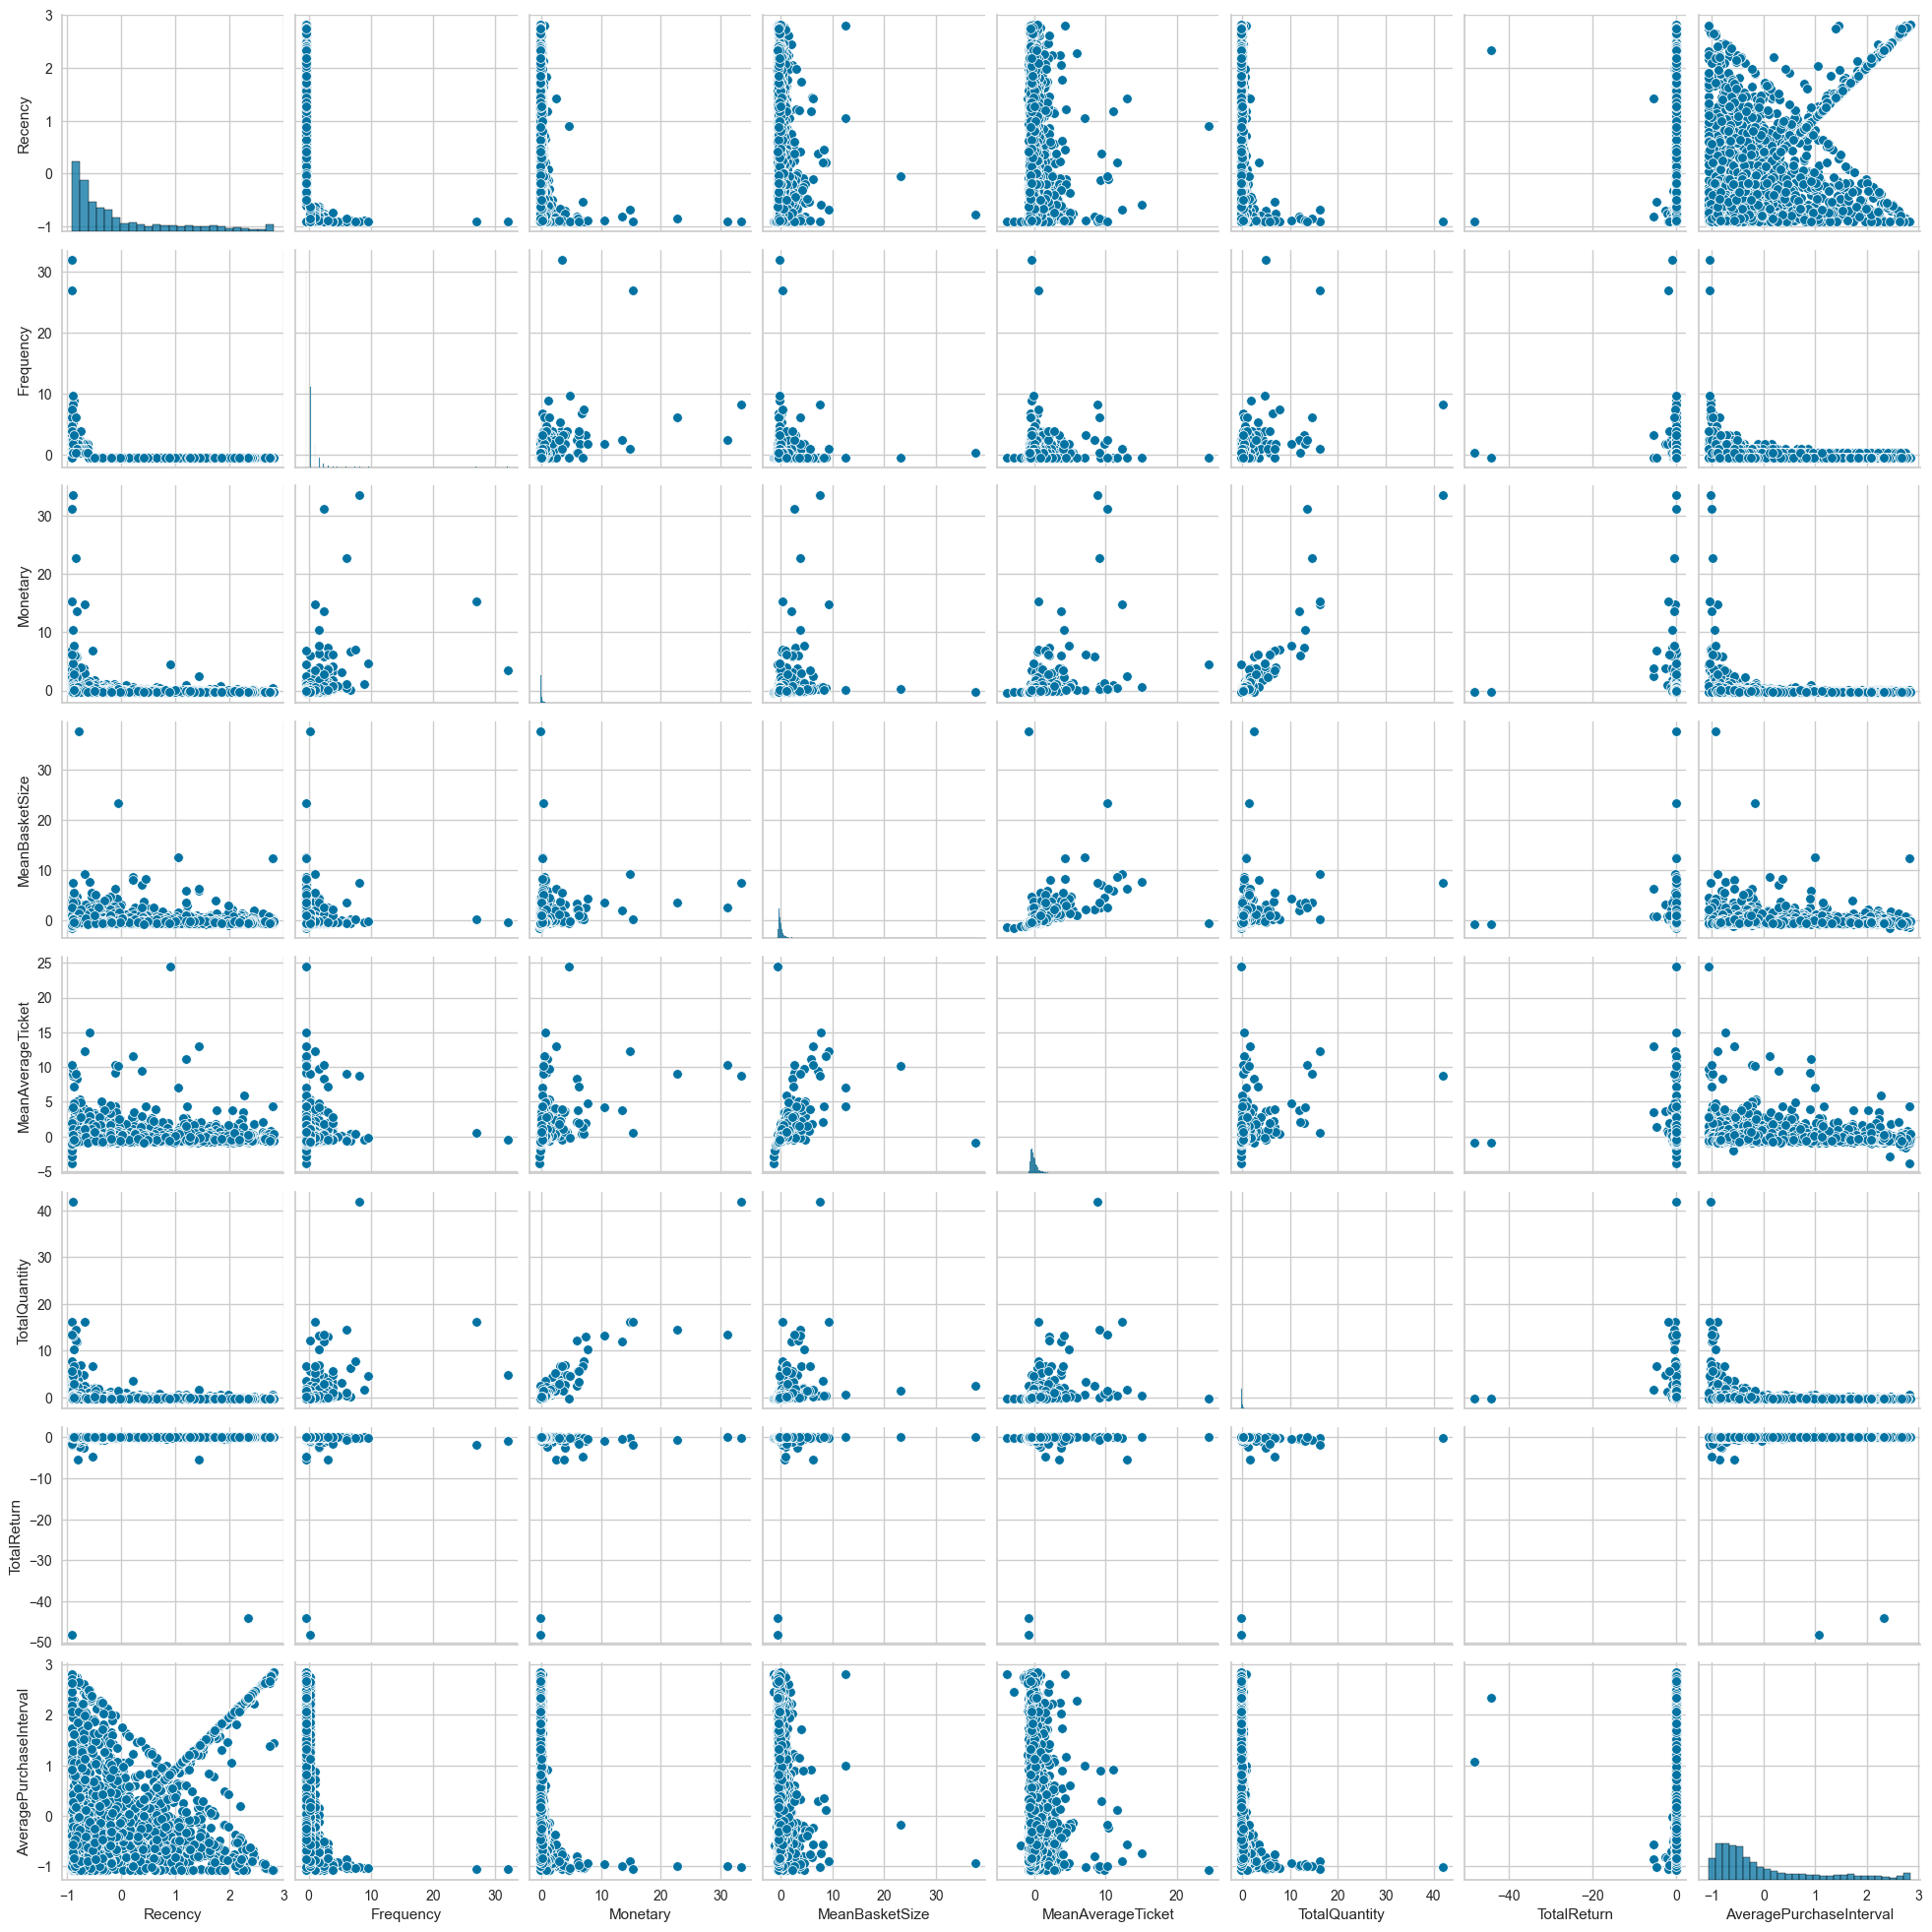

In [50]:
sns.pairplot(df8)

## 9.3. t-SNE

<Axes: xlabel='0', ylabel='1'>

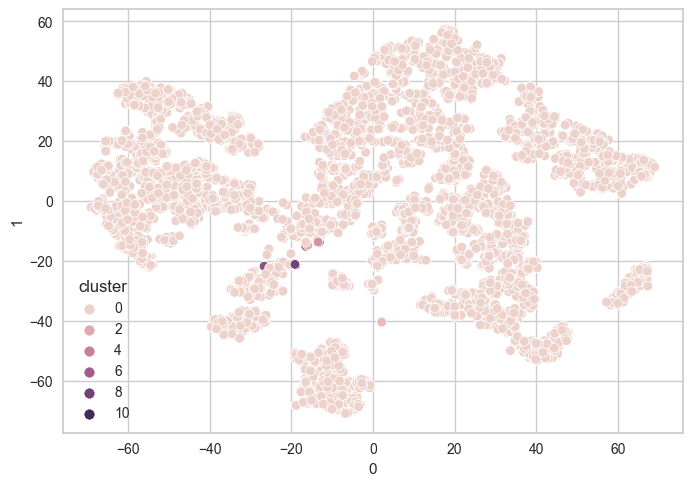

In [51]:
df_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = seed).fit_transform(df8)
df_embedded = pd.DataFrame(df_embedded)
df_embedded['cluster'] = final_pred
sns.scatterplot(x = 0, y = 1, data = df_embedded, hue = 'cluster')

## 9.4. Cluster Profile

In [52]:
df9.groupby('cluster').mean()

,Recency,Frequency,Monetary,MeanBasketSize,MeanAverageTicket,TotalQuantity,TotalReturn,AveragePurchaseInterval
cluster,,,,,,,,
0,0.000512,-0.017278,-0.029308,-0.020333,-0.019691,-0.025769,0.023205,0.001219
1,0.713270,-0.089944,-0.229643,-0.611012,-0.821814,-0.239919,-46.033375,1.701436
2,1.427504,-0.449640,2.376056,6.259364,12.933896,1.686519,-5.314475,-0.557865
3,-0.050910,-0.449640,0.292269,23.244983,10.201773,1.432168,0.036667,-0.165625
4,-0.840064,6.024875,22.728448,3.684307,9.070943,14.516685,-0.528486,-0.984506
5,0.898072,-0.449640,4.564197,-0.565528,24.485542,-0.227095,0.001048,-1.065162
6,-0.900000,8.183047,33.502715,7.510899,8.802950,41.894845,-0.134303,-1.017367
7,-0.909989,26.887201,15.365101,0.359409,0.537758,16.238787,-1.940774,-1.049552
8,-0.909989,2.427923,31.189081,2.646763,10.234739,13.465726,0.036667,-0.996592


# 10. DEPLOYMENT

## 10.1. Customer Segmentation Class

## 10.2. API Handler

## 10.3. API Tester